# Previous data import


In [10]:
import anndata as ad

# Load the AnnData object
adata = ad.read_h5ad('./data/adata.h5ad')

# Classifier for cell type prediction

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


In [12]:
# Extract the expression data and labels
X = adata[:, adata.var['highly_variable']].X
y = adata.obs['cell_classes'].astype('category').cat.codes.values

In [13]:
# Convert to PyTorch tensors
# X_tensor = torch.tensor(X.toarray(), dtype=torch.float32)
X_tensor = torch.tensor(X.toarray(), dtype=torch.bfloat16) # reduce memory usage
y_tensor = torch.tensor(y, dtype=torch.long)

In the following part I will stratify the data into 3 sets: training, validation and test.   
The data is very imbalanced and stratification ensures we have the same proportion of each class in each set. 
Also we will use weighted dataloader to handle the imbalance in the data during training, but there are many other techniques that could be used.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data.sampler import WeightedRandomSampler

# Define the split ratios
test_ratio = 0.1
validation_ratio = 0.1
train_ratio = 0.8

# Initialize StratifiedShuffleSplit for train and temp split
sss_train_temp = StratifiedShuffleSplit(n_splits=1, test_size=(test_ratio + validation_ratio), random_state=42)

# Split the data into train and temp (validation + test)
for train_index, temp_index in sss_train_temp.split(X, y):
    X_train, X_temp = X[train_index], X[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

# Initialize StratifiedShuffleSplit for validation and test split
sss_validation_test = StratifiedShuffleSplit(n_splits=1, test_size=(test_ratio / (test_ratio + validation_ratio)), random_state=42)

# Split the temp data into validation and test
for validation_index, test_index in sss_validation_test.split(X_temp, y_temp):
    X_validation, X_test = X_temp[validation_index], X_temp[test_index]
    y_validation, y_test = y_temp[validation_index], y_temp[test_index]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_validation_tensor = torch.tensor(X_validation.toarray(), dtype=torch.float32)
y_validation_tensor = torch.tensor(y_validation, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Calculate class weights
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])

# Create WeightedRandomSampler
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
import torch.nn.functional as F

class GeneExpressionClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(GeneExpressionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.drop2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop2(x)
        x = self.fc3(x)
        return x


In [19]:
# Initialize the model, loss function, and optimizer
input_dim = X.shape[1]
num_classes = len(set(y))
model = GeneExpressionClassifier(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()


# Training loop 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.optim import lr_scheduler

# create models folder if it doesn't exist
if not os.path.exists('./data/models'):
    os.makedirs('./data/models')

# Initialize a list to store the loss values
loss_values = []
val_loss_values = []

# Early stopping parameters
patience = 6
min_delta = 0.0001
best_val_loss = np.inf
patience_counter = 0

# Define the optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2, min_lr=1e-6)

# Training loop with loss tracking and early stopping
num_epochs = 100

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for inputs, labels in train_loader:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_epoch_loss)

    # Validation loss
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            epoch_val_loss += val_loss.item()

    avg_val_loss = epoch_val_loss / len(validation_loader)
    val_loss_values.append(avg_val_loss)

    # Adjust the learning rate based on validation loss
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, LR: {current_lr:.6f}')

    # Early stopping condition
    if best_val_loss - avg_val_loss > min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "./data/models/best_model.pth")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break



Epoch 1/100, Loss: 0.8028, Validation Loss: 0.9306, LR: 0.001000
Epoch 2/100, Loss: 0.5888, Validation Loss: 0.8624, LR: 0.001000
Epoch 3/100, Loss: 0.5250, Validation Loss: 0.9258, LR: 0.001000
Epoch 4/100, Loss: 0.4721, Validation Loss: 0.8849, LR: 0.001000
Epoch 5/100, Loss: 0.4212, Validation Loss: 0.8690, LR: 0.000100
Epoch 6/100, Loss: 0.3771, Validation Loss: 0.8610, LR: 0.000100
Epoch 7/100, Loss: 0.3620, Validation Loss: 0.8148, LR: 0.000100
Epoch 8/100, Loss: 0.3460, Validation Loss: 0.8594, LR: 0.000100
Epoch 9/100, Loss: 0.3335, Validation Loss: 0.8298, LR: 0.000100
Epoch 10/100, Loss: 0.3209, Validation Loss: 0.8327, LR: 0.000010
Epoch 11/100, Loss: 0.3119, Validation Loss: 0.8390, LR: 0.000010
Epoch 12/100, Loss: 0.3148, Validation Loss: 0.8570, LR: 0.000010
Epoch 13/100, Loss: 0.3082, Validation Loss: 0.8212, LR: 0.000001
Early stopping triggered at epoch 13


# Evaluation

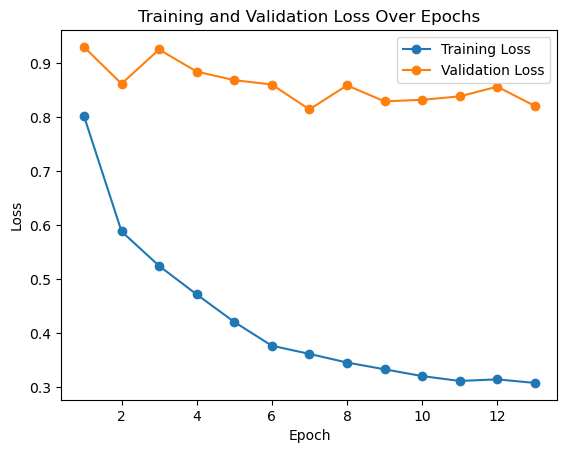

F1 Score: 0.7070994696122714
Macro F1 Score: 0.6229829638262356
Macro AUC-PR: 0.49836538250237683


In [21]:
# Plot the training and validation loss values
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Evaluation on the test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

# Compute macro F1 score
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f'Macro F1 Score: {macro_f1}')
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class classification
y_true_binarized = label_binarize(y_true, classes=range(num_classes))
y_pred_binarized = label_binarize(y_pred, classes=range(num_classes))

# Compute the average precision score for each class
average_precision = average_precision_score(y_true_binarized, y_pred_binarized, average='macro')
print(f'Macro AUC-PR: {average_precision}')

I selected a few metrics that focus on classe imbalance to evaluate the model performance,  
the results are not that great in that regard and would need more work to improve the model, fix the problems.  
We can also clearly see that the model is overfitting the training data, we could use more regularization techniques to fix that. 

Other possible improvements: 

- better analysis of the dataset to select better threashold for the gene cutoff, genes with high variability
- implement dimensionality reduction techniques like PCA, t-SNE, instead of the gene variability cutoff
- try transfer learning from other Single cell classifiers, ex: CellLM, scBiGNN, CTISL  
- try other techniques for class imbalance, like oversampling, undersampling, SMOTE, focal loss 
- use k fold cross validation to train on more of the data, especially minority classes 
- try other classifiers models and hyperparameters tuning
- try an auto encoder for feature selection from laten space then build classifier on top of it 